<a href="https://colab.research.google.com/github/gpasxos/large-scale-optimization/blob/main/ch05_Internet_flow_allocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We want to solve the problem:
$$\text{maximize}_{x\geq 0} \sum_{r=1}^R U_r(x_r) \\
\text{subject to}~~\sum_{r:\ell\in r}x_r\leq b_{\ell}$$
over a network graph that represents the connections of the Internet.

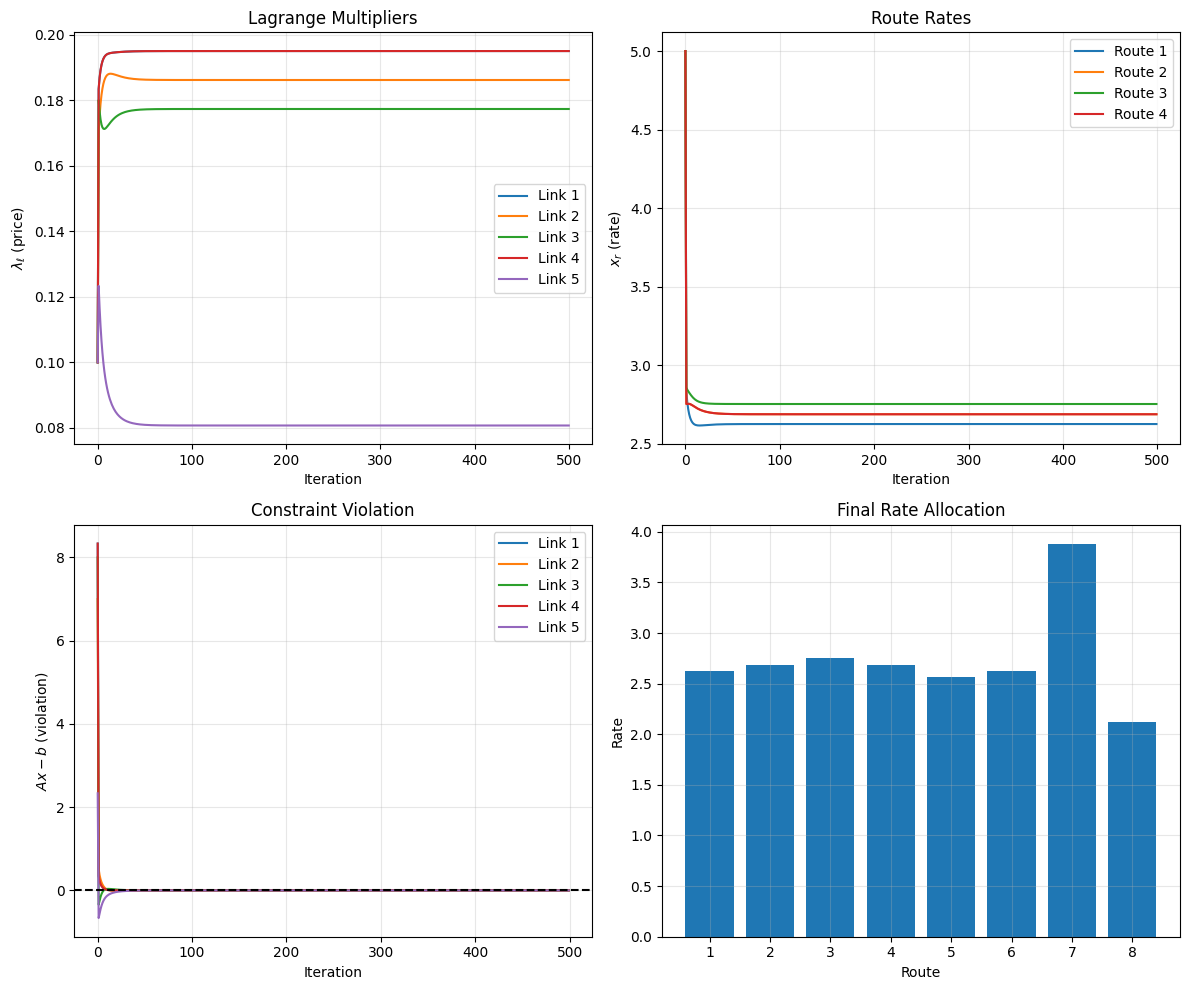

Final link utilization:
  Link 1: 10.00 / 10.0 (100.0%)
  Link 2: 8.00 / 8.0 (100.0%)
  Link 3: 12.00 / 12.0 (100.0%)
  Link 4: 10.00 / 10.0 (100.0%)
  Link 5: 6.00 / 6.0 (100.0%)


In [5]:
import numpy as np
import matplotlib.pyplot as plt

def congestion_control_dual_ascent():
    """
    Distributed congestion control via dual ascent.
    Utility: U_r(x) = w_r * log(x) (proportional fairness)
    """
    np.random.seed(42)

    # Network topology
    n_links = 5
    n_routes = 8

    # Routing matrix: A[l,r] = 1 if route r uses link l
    A = np.array([
        [1, 1, 0, 0, 1, 0, 0, 1],  # Link 1
        [1, 0, 1, 0, 0, 1, 0, 0],  # Link 2
        [0, 1, 1, 1, 0, 0, 1, 0],  # Link 3
        [0, 0, 0, 1, 1, 1, 0, 1],  # Link 4
        [0, 0, 0, 0, 0, 0, 1, 1],  # Link 5
    ], dtype=float)

    # Link capacities
    b = np.array([10, 8, 12, 10, 6], dtype=float)

    # Route weights (utility = w * log(x))
    w = np.ones(n_routes)

    def compute_rates(q, w):
        return w / np.maximum(q, 1e-8)

    # ============== FIX: Initialize lambda to small positive values ==============
    lam = 0.1 * np.ones(n_links)  # NOT np.zeros(n_links)!
    # =============================================================================

    eta = 0.01  # Step size
    n_iterations = 500  # More iterations for convergence

    history = {'lambda': [lam.copy()], 'x': [], 'constraint_violation': []}

    for k in range(n_iterations):
        q = A.T @ lam
        x = compute_rates(q, w)
        violation = A @ x - b
        lam = np.maximum(lam + eta * violation, 0)

        history['lambda'].append(lam.copy())
        history['x'].append(x.copy())
        history['constraint_violation'].append(violation.copy())

    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    lam_hist = np.array(history['lambda'])
    for l in range(n_links):
        axes[0, 0].plot(lam_hist[:, l], label=f'Link {l+1}')
    axes[0, 0].set_xlabel('Iteration')
    axes[0, 0].set_ylabel('$\\lambda_\\ell$ (price)')
    axes[0, 0].set_title('Lagrange Multipliers')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    x_hist = np.array(history['x'])
    for r in range(min(4, n_routes)):
        axes[0, 1].plot(x_hist[:, r], label=f'Route {r+1}')
    axes[0, 1].set_xlabel('Iteration')
    axes[0, 1].set_ylabel('$x_r$ (rate)')
    axes[0, 1].set_title('Route Rates')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    viol_hist = np.array(history['constraint_violation'])
    for l in range(n_links):
        axes[1, 0].plot(viol_hist[:, l], label=f'Link {l+1}')
    axes[1, 0].axhline(0, color='k', linestyle='--')
    axes[1, 0].set_xlabel('Iteration')
    axes[1, 0].set_ylabel('$Ax - b$ (violation)')
    axes[1, 0].set_title('Constraint Violation')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    x_final = history['x'][-1]
    axes[1, 1].bar(range(1, n_routes+1), x_final)
    axes[1, 1].set_xlabel('Route')
    axes[1, 1].set_ylabel('Rate')
    axes[1, 1].set_title('Final Rate Allocation')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('congestion_control.pdf', bbox_inches='tight')
    plt.show()

    print("Final link utilization:")
    for l in range(n_links):
        usage = A[l] @ x_final
        print(f"  Link {l+1}: {usage:.2f} / {b[l]:.1f} ({100*usage/b[l]:.1f}%)")

congestion_control_dual_ascent()